## pyKO Test 4
### Al->Al plate impact, planar, free surfaces
### pyKO: SESAME TABLE Al model vs fKO: Mie Grueneisen Al model

WARNING: The Al SESAME Table is NOT a full EOS model. It is an approximation of the Mie Grueneisen Al model just to check that the tabular EOS feature is working in pyKO.

NOTE: fortran version is hard-coded to 500 nodes for these tests. Edit and recompile if needed.

pyKO documentation: https://impactswiki.github.io/pyko

Set the path to pyko and your fortran compiler in import-modules.py file

Sarah T. Stewart<br>
June 27, 2023<br>

In [1]:
# import the same set of modules for each test run provided with pyKO
%run import-modules

Platform:  Darwin Kernel Version 22.5.0: Thu Jun  8 22:21:34 PDT 2023; root:xnu-8796.121.3~7/RELEASE_ARM64_T8112
python version:  3.11.4
matplotlib version:  3.7.1
hvplot version:  0.8.4
numpy version:  1.25.0
pandas version:  2.0.2
pickle version:  4.0
yaml version:  6.0
pint version:  0.22
pyko version:  v0.6.1-2023-07-04

/usr/local/bin/gfortran

GNU Fortran (GCC) 12.1.0
Copyright (C) 2022 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.




## Example of checking EOS table initial state and verifying input file OK

EOS Tables are initialized based on the user input density and internal energy (you could change that if desired). In v0.4, the input P and T are over-ridden by the EOS Table state variables for the given density and energy.

In [2]:
# start with your initial guess of the EOS initial state 
# load and print the configuration file without running the simulation
# 
filein = './test4/test4-sesplates.yml'
# initialize the run class variable by loading the configuration file
# this loads the requires EOS tables, so you can inquire about initial states
run = RunClass(fin=filein)
# print the run class state; this will print in code units
run.checkinput()


Key nrhomin does not exist. Using default 0.8
Key nrhomin does not exist. Using default 0.8

pyKO v0.6.1-2023-07-04 run parameters
   All outputs are in code units 
   Input file: ./test4/test4-sesplates.yml 
   Output file: ./test4/pyko-test4-sesplates-bin.dat 
   Number of materials: 2 
   Number of nodes in each material: [200 300] 
   Length of each material: [2. 3.] 
   Initial left edge of each material: [0. 2.] 
   Boundary conditions: ['FREE', 'FREE']
   Material EOS:     ['SES', 'SES'] 
   Geometry:         PLA 
   Gravity:          0.0 
   Void pressure:    1e-09 
   Time step factor: 6 
   Stop time:        10.0

mat1 Von Mises parameters: 
   Shear modulus: 0.24800000000000003 
   Yield stress: 0.006000000000000001

mat1 Fracture parameters [code units]: 
   Fracture pressure: 1000000000.0000001 
   Fracture maximum distension (rhomin/rhoref): 0.8

Class SESAME [code units]: Al 1 
   eos_table module version v1.1.5 
   table path: ../eos/aneos-Al-demo/ 
   file names: NEW-S

In [3]:
# query the SESAME table for the correct pressure and sp. internal energy
# given an initial density and temperature
p,u,cs = run.ieos[0].onepuc(2.7,298)
print(p,u,cs)
# p and u and cs are in code units: Mbar and eu/g and 10 km/s
print('\n****************')
print('For specified rho and T combination, the table EOS pressure and internal energy and sound speed are = ',p, u, cs)
# use pint to help you convert code units internal energy to mks
ureg.define('eu = 1.0E12 ergs') 
utmp = Q_(u,'eu/g') # creates a variable utmp that has pint units information
print('internal energy in code units: ',utmp) # prints the value and units
print('internal energy in mks units: ',utmp.to('J/kg')) # prints the value and units
print('pressure in mks units: ',p*1.e11) # Mbar to Pa
print('sound speed in mks units: ',cs*1.e4)


2.3113752999999998e-06 0.0015514308799999996 0.518892471

****************
For specified rho and T combination, the table EOS pressure and internal energy and sound speed are =  2.3113752999999998e-06 0.0015514308799999996 0.518892471
internal energy in code units:  0.0015514308799999996 eu / gram
internal energy in mks units:  155143.08799999996 joule / kilogram
pressure in mks units:  231137.52999999997
sound speed in mks units:  5188.92471


### Run python KO

Fortan version uses an initial time step of 0.001 microseconds; set as input here for code comparison.

Otherwise pyKO has an initialization section that estimates a good first time step


In [4]:
# fortan uses an initial time step of 0.001 microseconds; set as input here for code comparison
# otherwise pyKO has an initialization section that estimates a good first time step
# reducing the Wilkins time step by a factor of 6 provides 99% energy conservation
# fortran KO uses scale factor of 6 hard coded; use 6 for direct comparison

%time pyko.run(fin=filein,usertstepscale=6.,userdtstart=0.001,verbose=True)


Key nrhomin does not exist. Using default 0.8
Key nrhomin does not exist. Using default 0.8

pyKO v0.6.1-2023-07-04 run parameters
   All outputs are in code units 
   Input file: ./test4/test4-sesplates.yml 
   Output file: ./test4/pyko-test4-sesplates-bin.dat 
   Number of materials: 2 
   Number of nodes in each material: [200 300] 
   Length of each material: [2. 3.] 
   Initial left edge of each material: [0. 2.] 
   Boundary conditions: ['FREE', 'FREE']
   Material EOS:     ['SES', 'SES'] 
   Geometry:         PLA 
   Gravity:          0.0 
   Void pressure:    1e-09 
   Time step factor: 6 
   Stop time:        10.0

mat1 Von Mises parameters: 
   Shear modulus: 0.24800000000000003 
   Yield stress: 0.006000000000000001

mat1 Fracture parameters [code units]: 
   Fracture pressure: 1000000000.0000001 
   Fracture maximum distension (rhomin/rhoref): 0.8

Class SESAME [code units]: Al 1 
   eos_table module version v1.1.5 
   table path: ../eos/aneos-Al-demo/ 
   file names: NEW-S

## Load Python KO results

In [5]:
# pyko output filename is in the input file
pykofileout = run.outputfilename
# initialize a class object to hold the output data
pko = [] # this variable will hold a plain (no units) pandas datafram for plotting
pkodata = OutputClass() # pandas + pint dataframe to read the pickled output data
#
# function to convert the stored pandas structure with pint units to a normal panda file
# hvplot tools do not work with a panda+pint file
# this also lets the user select a subset of variables to read into this notebook
def pyko_to_normal_panda(pkodata):
    df = pd.DataFrame({
            "j"    : pkodata.j.magnitude,
            "stepn" : pkodata.stepn.magnitude,
            "time" : pkodata.time.magnitude,
            "mat" : pkodata.mat.magnitude,
            "pos" : pkodata.pos.magnitude,
            "rho0" : pkodata.rho0.magnitude,
            "rho" : pkodata.rho.magnitude,
            "up" : pkodata.up.magnitude,
            "ie" : pkodata.ie.magnitude,
            "pres" : pkodata.pres.magnitude,
            "mass" : pkodata.mass.magnitude,
            "temp" : pkodata.temp.magnitude,
            "sigmar" : pkodata.sigmar.magnitude,
            "sigmao" : pkodata.sigmao.magnitude,
            "etot" : pkodata.etot.magnitude,
            "dtminj" : pkodata.dtminj.magnitude,
            })
    return df
#
# loop through all the pickle dumps to read in the simulation data
# concat onto a pandas dataframe that stores the variables vs. time
with open(pykofileout,"rb") as f:
    pkodata = pickle.load(f) # keeps units
    if 1:
        # print units
        print('pyKO output file units are the same as the input file units:')
        print('   Time        ',pkodata.time.units)
        print('   Position    ',pkodata.pos.units)
        print('   Density     ',pkodata.rho.units)
        print('   Part. vel.  ',pkodata.up.units)
        print('   Int. energy ',pkodata.ie.units)
        print('   Mass        ',pkodata.mass.units)
        print('   Temperature ',pkodata.temp.units)
        print('   Pressure    ',pkodata.pres.units)
        print('   Stress      ',pkodata.sigmar.units)
    pko = pyko_to_normal_panda(pkodata)
    while True:
        try:
            pkodata = pickle.load(f) # keeps units but only one snapshot at a time
            pko = pd.concat([pko,pyko_to_normal_panda(pkodata)],ignore_index=True) # strips units for plotting
        except:
            break

# convert to same units as fKO for plot comparisons
# from binary in mks
pko['ie']     *= 1.E-11*pko['rho0']    # J/kg * kg/m3 -> 100 GJ/m3 = eu/cm3
pko.rename(columns={"ie": "iev0"},inplace=True)
pko['etot']   *= 1.E-8    # J/kg 10e7 erg/1000 g -> erg/g *1.e-12 -> eu/g
print('iev0 and etot converted to eu/g')
pko['time']   *= 1.0E6    # s->microseconds
pko['dtminj'] *= 1.0E6    # s->microseconds
pko['pos']    *= 1.0E2    # m->cm
pko['pres']   *= 1.E-9    # Pa -> GPa
pko['sigmar'] *= 1.E-9    # Pa -> GPa
pko['sigmao'] *= 1.E-9    # Pa -> GPa
pko['rho']    *= 1.E-3    # kg/m3 -> g/cm3
pko['rho0']   *= 1.E-3    # kg/m3 -> g/cm3

# list the columns in the dataframe
pko.columns


pyKO output file units are the same as the input file units:
   Time         second
   Position     meter
   Density      kilogram / meter ** 3
   Part. vel.   meter / second
   Int. energy  joule / kilogram
   Mass         kilogram
   Temperature  kelvin
   Pressure     pascal
   Stress       pascal
iev0 and etot converted to eu/g


Index(['j', 'stepn', 'time', 'mat', 'pos', 'rho0', 'rho', 'up', 'iev0', 'pres',
       'mass', 'temp', 'sigmar', 'sigmao', 'etot', 'dtminj'],
      dtype='object')

In [6]:
display(pko)

,j,stepn,time,mat,pos,rho0,rho,up,iev0,pres,mass,temp,sigmar,sigmao,etot,dtminj
0,1,0,0.000000,1,0.010000,2.7,2.700000,500.000000,0.004189,0.000231,0.000054,298.000000,0.000000,0.000000,0.027644,0.000000
1,3,0,0.000000,1,0.030000,2.7,2.700000,500.000000,0.004189,0.000231,0.000054,298.000000,0.000000,0.000000,0.027644,0.000000
2,5,0,0.000000,1,0.050000,2.7,2.700000,500.000000,0.004189,0.000231,0.000054,298.000000,0.000000,0.000000,0.027644,0.000000
3,7,0,0.000000,1,0.070000,2.7,2.700000,500.000000,0.004189,0.000231,0.000054,298.000000,0.000000,0.000000,0.027644,0.000000
4,9,0,0.000000,1,0.090000,2.7,2.700000,500.000000,0.004189,0.000231,0.000054,298.000000,0.000000,0.000000,0.027644,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250245,491,2621,10.003292,2,5.145956,2.7,2.709039,484.398794,0.004247,0.258110,0.000054,301.946038,0.000014,-0.387195,0.027607,0.025441
250246,493,2621,10.003292,2,5.165901,2.7,2.705716,484.399276,0.004222,0.162511,0.000054,300.329952,0.000102,-0.243803,0.027607,0.025535
250247,495,2621,10.003292,2,5.185878,2.7,2.700490,484.397989,0.004190,0.013890,0.000054,298.144166,-0.000086,-0.020807,0.027607,0.025682
250248,497,2621,10.003292,2,5.205876,2.7,2.699994,484.398658,0.004188,-0.000051,0.000054,297.970801,0.000135,0.000021,0.027607,0.025696


In [7]:
# plotting range for position axis
xr = [-1,6]

In [36]:
pko.hvplot.scatter(x='pos',y='pres',groupby='time',by='mat',hover_cols=['all'],
                       title='pyKO vs. Time (microseconds)',
                       xlabel='Position (cm)',ylabel='Pressure (GPa)',xlim=xr)

:DynamicMap   [time]
   :NdOverlay   [mat]
      :Scatter   [pos]   (pres)

In [37]:
pko.hvplot.scatter(x='pos',y='up',groupby='time',by='mat',hover_cols=['all'],
                       title='pyKO vs Time (microseconds)',
                       xlabel='Position (cm)',ylabel='Particle Velocity (m/s)',xlim=xr)

:DynamicMap   [time]
   :NdOverlay   [mat]
      :Scatter   [pos]   (up)

In [38]:
pko.hvplot.scatter(x='pos',y='iev0',groupby='time',by='mat',hover_cols=['all'],
                       title='pyKO vs Time (microseconds)',
                       xlabel='Position (cm)',ylabel='Internal Energy (eu/cm3)',xlim=xr)  

:DynamicMap   [time]
   :NdOverlay   [mat]
      :Scatter   [pos]   (iev0)

In [39]:
pko.hvplot.scatter(x='pos',y='rho',groupby='time',by='mat',hover_cols=['all'],
                       title='pyKO vs Time (microseconds)',
                       xlabel='Position (cm)',ylabel='Density (g/cm3)',xlim=xr,ylim=[2.55,2.85])  

:DynamicMap   [time]
   :NdOverlay   [mat]
      :Scatter   [pos]   (rho)

In [12]:
pko.hvplot.scatter(x='pos',y='sigmar',groupby='time',by='mat',hover_cols=['all'],
                       title='pyKO vs Time (microseconds)',
                       xlabel='Position (cm)',ylabel='sigmar (GPa)')#,ylim=[-.5,5])

:DynamicMap   [time]
   :NdOverlay   [mat]
      :Scatter   [pos]   (sigmar)

In [40]:
pko.hvplot.scatter(x='pos',y='temp',groupby='time',by='mat',hover_cols=['all'],
                       title='pyKO vs Time (microseconds)',
                       xlabel='Position (cm)',ylabel='Temperature (K)',xlim=xr)#,ylim=[270,350])  

:DynamicMap   [time]
   :NdOverlay   [mat]
      :Scatter   [pos]   (temp)

## Run Fortran KO 

### Compile fortran KO

Compile at the command line; an example Makefile is provided.


In [14]:
# Al heat capacity 0.9 J/K/kg https://www.periodic-table.org/Aluminium-specific-heat/
cv_sp = 900 # J/K/kg
rho_kg = 2700. #kg/m3
# convert to code units
eu = 100e3 # J -> eu ; code energy unit eu = 100 kJ
#P_code = P/1.e11 # Pa -> Mbar
rho_code = rho_kg/1000. # kg/m3 ->> g/cm3

#E_code = E*rho_code / 1.e11 # eu/cm3 = 100 GJ/m3
cv_code = cv_sp * rho_kg /1.e11 # eu/K/cm3 = 100 GJ/K/m3
print(cv_code)

E_mks = 7.367090e6 # J/kg
E_code = E_mks*rho_kg/1.e11 # 100 GJ/m3
print(E_code)

2.43e-05
0.19891143


In [15]:
filein = './test4/test4-mgrunplates.in'
fkofileout = './test4/fko-test4-mgrunplates.dat'


In [16]:
# The third input argument is the amount of time between writing output snapshots

%time os.system('../kov11e '+filein+' '+fkofileout+' 0.1')

 ./test4/test4-mgrunplates.in            ./test4/fko-test4-mgrunplates.dat         0.10000000000000001     
 input file: ./test4/test4-mgrunplates.in            
 EOS input
   1   1 200     2.0000     0.0000     0.0000     0.0500     2.7000     0.0043     2.7000     0.5200     1.5000     0.0000     2.0000     0.0060     0.2480  0.1000E+10  0.2430E-04
   2   1 300     3.0000     2.0000     0.0000     0.0000     2.7000     0.0043     2.7000     0.5200     1.5000     0.0000     2.0000     0.0060     0.2480  0.1000E+10  0.2430E-04
  
 Boundary Conditions
  -1  0.000  0.000  2.700  0.000  1.000
   1  0.000  0.000  2.700  0.000  1.000
 output file: ./test4/fko-test4-mgrunplates.dat       
 Start Main Loop,  goto tstop =    10.000000000000000     
 Fortran KO time in main loop =    1.1253210000000000     
 *******************  Finished!!  ******************
CPU times: user 2.05 ms, sys: 1.92 ms, total: 3.97 ms
Wall time: 1.16 s


0

### Load Fortran KO results


In [17]:
# read the data file: ko-fort.dat
# this is a dump of each node for each time step and has a shape of [(nodes x timesteps), # output variables]
# it is faster to read an ascii file all at once rather than line by line
# this formulation of opening a file will automatically close the file
# see https://www.statology.org/with-open-python/
with open(fkofileout) as f:
    fko = pd.read_csv(f, delimiter=r"\s+") # read into a Pandas array; stsm added headers to the output file

# convert to plotting units 
# 
fko['pres']   *= 100. # Mbar to GPa                   # numpy version ko[:,variable_index]
fko['up']     *= 10000. # cm/us to m/s particle velocity
fko['sigmar'] *= 100 # Mbar to GPa total normal stress
fko['sigmao'] *= 100 # Mbar to GPa total normal stress
#column_names = list(fko)

#adding to the plots below as a constant offset
fkoe0 =  0.004233839731905622 #fKO mie grueneisen model does not use the E0 value in the input file; 
fkot0 =  300 #fKO mie grueneisen model does not use the E0 value in the input file; 

fko['iev0'] += fkoe0 # eu/cm3
fko['temp'] += fkot0 # K


In [18]:
fko.hvplot.scatter(x='pos',y='pres',groupby='time',by='mat',hover_cols=['all'],
                       title='fKO vs. Time (microseconds)',
                       xlabel='Position (cm)',ylabel='Pressure (GPa)',xlim=xr)

:DynamicMap   [time]
   :NdOverlay   [mat]
      :Scatter   [pos]   (pres)

In [19]:
fko.hvplot.scatter(x='pos',y='up',groupby='time',by='mat',hover_cols=['all'],
                       title='fKO vs. Time (microseconds)',
                       xlabel='Position (cm)',ylabel='Particle Velocity (m/s)',xlim=xr)

:DynamicMap   [time]
   :NdOverlay   [mat]
      :Scatter   [pos]   (up)

In [20]:
fko.hvplot.scatter(x='pos',y='temp',groupby='time',by='mat',hover_cols=['all'],
                       title='fKO vs. Time (microseconds)',
                       xlabel='Position (cm)',ylabel='Temperature (K)',xlim=xr,ylim=[270,350])

:DynamicMap   [time]
   :NdOverlay   [mat]
      :Scatter   [pos]   (temp)

## Compare Python and Fortran KO results

At this time, the Pandas DataFrame indexes do not align when comparing pyKO binary and fKO ascii output.

In [21]:
title='Test 4: pyKO SES vs. fKO mgrun'

# select a range of time; plots will be versus the Pandas data frame index number in this time range
# the f/pindex corresponds to index position in the dataframe, which correspond to the spatial dimension
#t1 = 0.11 # microsec
#t2 = 0.15 # microsec
#t1 = 0.71 # microsec
#t2 = 0.75 # microsec
#t1 = 1.015 # microsec
#t2 = 1.063 # microsec
t1 = 4.1 # microsec
t2 = 4.15 # microsec

ftime = np.unique(fko["time"])
ptime = np.unique(pko["time"])
fsteps = np.unique(fko["step"])
psteps = np.unique(pko["stepn"])
findex = np.where((fko["time"] > t1) & (fko["time"] < t2))[0]
findex = findex-findex[0]
pindex = np.where((pko["time"] > t1) & (pko["time"] < t2))[0]
pindex = pindex-pindex[0]
print('Number of elements in selected time window (fKO, pKO): ',len(findex),len(pindex))
print('Number of elements time array (fKO, pKO): ',len(ftime),len(ptime))


Number of elements in selected time window (fKO, pKO):  753 1250
Number of elements time array (fKO, pKO):  633 1001


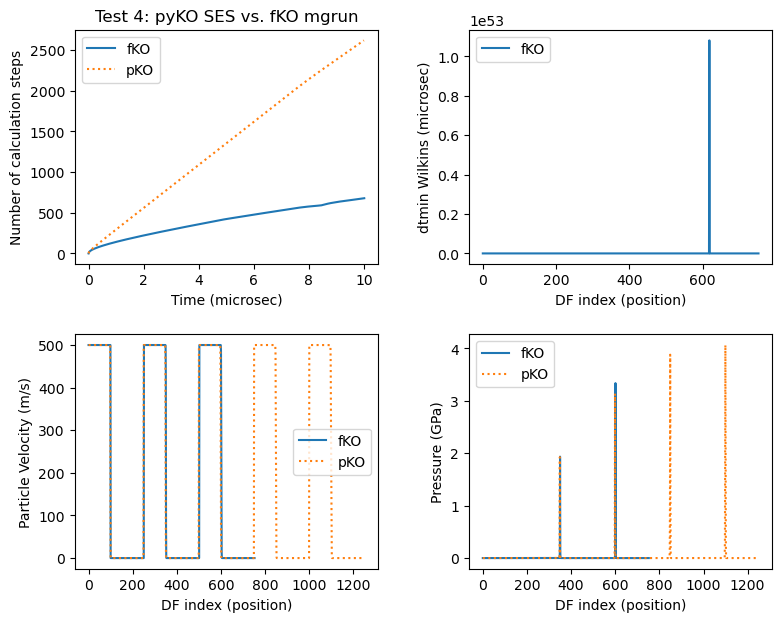

In [22]:

plt.rcParams["figure.figsize"] = (9,7)

figb, axs = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

axs[0,0].set_xlabel('Time (microsec)')
axs[0,0].set_ylabel('Number of calculation steps')


axs[0,1].set_xlabel('DF index (position)')
axs[0,1].set_ylabel('dtmin Wilkins (microsec)')


axs[1,1].set_xlabel('DF index (position)')
axs[1,1].set_ylabel('Pressure (GPa)')

axs[1,0].set_xlabel('DF index (position)')
axs[1,0].set_ylabel('Particle Velocity (m/s)')

# add title of the problem and time to the top of the plot
axs[0,0].set_title(title)

fig00a,=axs[0,0].plot(fko["time"],fko["step"],label='fKO')
fig00b,=axs[0,0].plot(pko["time"],pko["stepn"],':',label='pKO')
axs[0,0].legend()

fig01a,=axs[0,1].plot(fko["dtminj"][findex],label='fKO')
#fig01b,=axs[0,1].plot(pko["dtminj"][pindex],':',label='pKO')
axs[0,1].legend()

fig11a,=axs[1,1].plot(fko["pres"][findex],label='fKO')
fig11b,=axs[1,1].plot(pko["pres"][pindex],':',label='pKO')
axs[1,1].legend()

fig10a,=axs[1,0].plot(fko["up"][findex],label='fKO')
fig10b,=axs[1,0].plot(pko["up"][pindex],':',label='pKO')
axs[1,0].legend()



633 1001
633 1001
633 1001


Text(0, 0.5, 'sigmar (Mbar)')

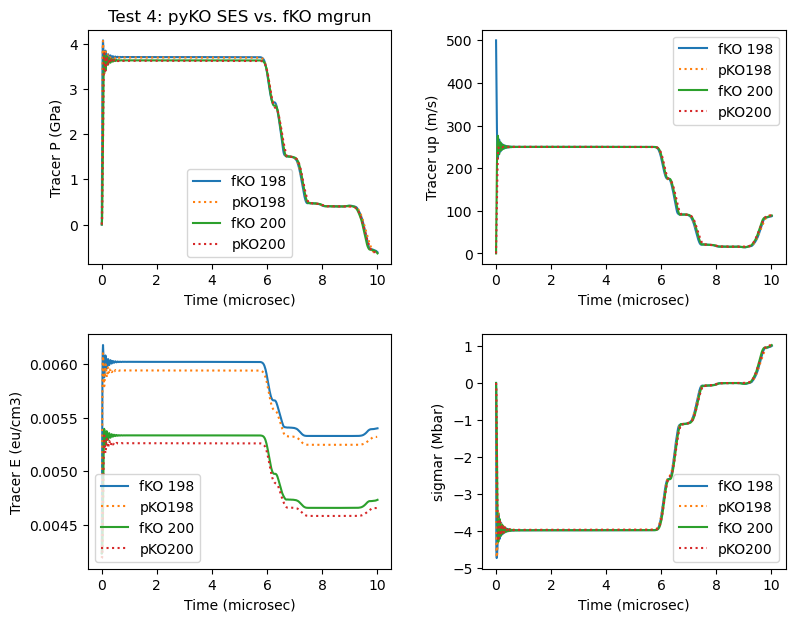

In [23]:
print(len(ftime),len(ptime))
jtarr = [198, 200]
findex0 = np.where((fko["j"] == jtarr[0]))[0]
pindex0 = np.where((pko["j"] == jtarr[0]+1))[0]
if len(findex0) > len(ftime):
    findex0 = np.delete(findex0,-1)
#while len(pindex0) > len(findex0):
#    pindex0 = np.delete(pindex0,-1)
print(len(findex0),len(pindex0))

findex1 = np.where((fko["j"] == jtarr[1]))[0]
pindex1 = np.where((pko["j"] == jtarr[1]+1))[0]
if len(findex1) > len(findex0):
    findex1 = np.delete(findex1,-1)
if len(findex1) > len(pindex1):
    findex1 = np.delete(findex1,-1)
#while len(pindex1) > len(findex1):
#    pindex1 = np.delete(pindex1,-1)
print(len(findex1),len(pindex1))

plt.rcParams["figure.figsize"] = (9,7)

figb, axs = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# add title of the problem and time to the top of the plot
axs[0,0].set_title(title)

axs[0,0].plot(ftime,fko["pres"][findex0],label='fKO '+str(jtarr[0]))
axs[0,0].plot(ptime,pko["pres"][pindex0],':',label='pKO'+str(jtarr[0]))
axs[0,0].plot(ftime,fko["pres"][findex1],label='fKO '+str(jtarr[1]))
axs[0,0].plot(ptime,pko["pres"][pindex1],':',label='pKO'+str(jtarr[1]))
axs[0,0].legend()
axs[0,0].set_xlabel('Time (microsec)')
axs[0,0].set_ylabel('Tracer P (GPa)')

axs[0,1].plot(ftime,fko["up"][findex0],label='fKO '+str(jtarr[0]))
axs[0,1].plot(ptime,pko["up"][pindex0],':',label='pKO'+str(jtarr[0]))
axs[0,1].plot(ftime,fko["up"][findex1],label='fKO '+str(jtarr[1]))
axs[0,1].plot(ptime,pko["up"][pindex1],':',label='pKO'+str(jtarr[1]))
axs[0,1].legend()
axs[0,1].set_xlabel('Time (microsec)')
axs[0,1].set_ylabel('Tracer up (m/s)')

axs[1,0].plot(ftime,fko["iev0"][findex0],label='fKO '+str(jtarr[0]))
axs[1,0].plot(ptime,pko["iev0"][pindex0],':',label='pKO'+str(jtarr[0]))
axs[1,0].plot(ftime,fko["iev0"][findex1],label='fKO '+str(jtarr[1]))
axs[1,0].plot(ptime,pko["iev0"][pindex1],':',label='pKO'+str(jtarr[1]))
axs[1,0].legend()
axs[1,0].set_xlabel('Time (microsec)')
axs[1,0].set_ylabel('Tracer E (eu/cm3)')

axs[1,1].plot(ftime,fko["sigmar"][findex0],label='fKO '+str(jtarr[0]))
axs[1,1].plot(ptime,pko["sigmar"][pindex0],':',label='pKO'+str(jtarr[0]))
axs[1,1].plot(ftime,fko["sigmar"][findex1],label='fKO '+str(jtarr[1]))
axs[1,1].plot(ptime,pko["sigmar"][pindex1],':',label='pKO'+str(jtarr[1]))
axs[1,1].legend()
axs[1,1].set_xlabel('Time (microsec)')
axs[1,1].set_ylabel('sigmar (Mbar)')


633 1001
633 1001
633 1001


Text(0, 0.5, 'sigmar (Mbar)')

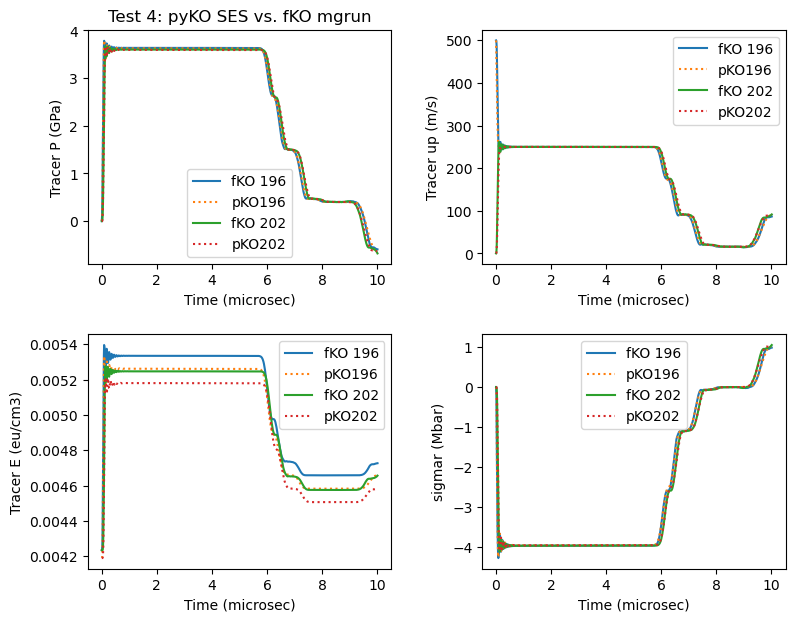

In [24]:
print(len(ftime),len(ptime))
jtarr = [196, 202]
findex0 = np.where((fko["j"] == jtarr[0]))[0]
pindex0 = np.where((pko["j"] == jtarr[0]+1))[0]
if len(findex0) > len(ftime):
    findex0 = np.delete(findex0,-1)
#while len(pindex0) > len(findex0):
#    pindex0 = np.delete(pindex0,-1)
print(len(findex0),len(pindex0))

findex1 = np.where((fko["j"] == jtarr[1]))[0]
pindex1 = np.where((pko["j"] == jtarr[1]+1))[0]
if len(findex1) > len(findex0):
    findex1 = np.delete(findex1,-1)
if len(findex1) > len(pindex1):
    findex1 = np.delete(findex1,-1)
#while len(pindex1) > len(findex1):
#    pindex1 = np.delete(pindex1,-1)
print(len(findex1),len(pindex1))

plt.rcParams["figure.figsize"] = (9,7)

figb, axs = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# add title of the problem and time to the top of the plot
axs[0,0].set_title(title)

axs[0,0].plot(ftime,fko["pres"][findex0],label='fKO '+str(jtarr[0]))
axs[0,0].plot(ptime,pko["pres"][pindex0],':',label='pKO'+str(jtarr[0]))
axs[0,0].plot(ftime,fko["pres"][findex1],label='fKO '+str(jtarr[1]))
axs[0,0].plot(ptime,pko["pres"][pindex1],':',label='pKO'+str(jtarr[1]))
axs[0,0].legend()
axs[0,0].set_xlabel('Time (microsec)')
axs[0,0].set_ylabel('Tracer P (GPa)')

axs[0,1].plot(ftime,fko["up"][findex0],label='fKO '+str(jtarr[0]))
axs[0,1].plot(ptime,pko["up"][pindex0],':',label='pKO'+str(jtarr[0]))
axs[0,1].plot(ftime,fko["up"][findex1],label='fKO '+str(jtarr[1]))
axs[0,1].plot(ptime,pko["up"][pindex1],':',label='pKO'+str(jtarr[1]))
axs[0,1].legend()
axs[0,1].set_xlabel('Time (microsec)')
axs[0,1].set_ylabel('Tracer up (m/s)')

axs[1,0].plot(ftime,fko["iev0"][findex0],label='fKO '+str(jtarr[0]))
axs[1,0].plot(ptime,pko["iev0"][pindex0],':',label='pKO'+str(jtarr[0]))
axs[1,0].plot(ftime,fko["iev0"][findex1],label='fKO '+str(jtarr[1]))
axs[1,0].plot(ptime,pko["iev0"][pindex1],':',label='pKO'+str(jtarr[1]))
axs[1,0].legend()
axs[1,0].set_xlabel('Time (microsec)')
axs[1,0].set_ylabel('Tracer E (eu/cm3)')

axs[1,1].plot(ftime,fko["sigmar"][findex0],label='fKO '+str(jtarr[0]))
axs[1,1].plot(ptime,pko["sigmar"][pindex0],':',label='pKO'+str(jtarr[0]))
axs[1,1].plot(ftime,fko["sigmar"][findex1],label='fKO '+str(jtarr[1]))
axs[1,1].plot(ptime,pko["sigmar"][pindex1],':',label='pKO'+str(jtarr[1]))
axs[1,1].legend()
axs[1,1].set_xlabel('Time (microsec)')
axs[1,1].set_ylabel('sigmar (Mbar)')


633 1001
633 1001
633 1001


Text(0, 0.5, 'sigmar (Mbar)')

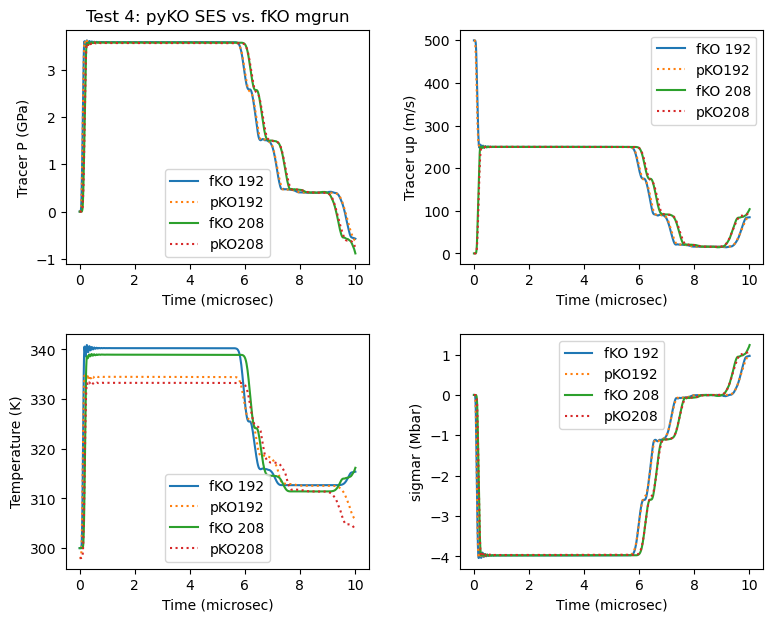

In [25]:
print(len(ftime),len(ptime))
jtarr = [192, 208]
findex0 = np.where((fko["j"] == jtarr[0]))[0]
pindex0 = np.where((pko["j"] == jtarr[0]+1))[0]
if len(findex0) > len(ftime):
    findex0 = np.delete(findex0,-1)
#while len(pindex0) > len(findex0):
#    pindex0 = np.delete(pindex0,-1)
print(len(findex0),len(pindex0))

findex1 = np.where((fko["j"] == jtarr[1]))[0]
pindex1 = np.where((pko["j"] == jtarr[1]+1))[0]
if len(findex1) > len(findex0):
    findex1 = np.delete(findex1,-1)
if len(findex1) > len(pindex1):
    findex1 = np.delete(findex1,-1)
#while len(pindex1) > len(findex1):
#    pindex1 = np.delete(pindex1,-1)
print(len(findex1),len(pindex1))

plt.rcParams["figure.figsize"] = (9,7)

figb, axs = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# add title of the problem and time to the top of the plot
axs[0,0].set_title(title)

axs[0,0].plot(ftime,fko["pres"][findex0],label='fKO '+str(jtarr[0]))
axs[0,0].plot(ptime,pko["pres"][pindex0],':',label='pKO'+str(jtarr[0]))
axs[0,0].plot(ftime,fko["pres"][findex1],label='fKO '+str(jtarr[1]))
axs[0,0].plot(ptime,pko["pres"][pindex1],':',label='pKO'+str(jtarr[1]))
axs[0,0].legend()
axs[0,0].set_xlabel('Time (microsec)')
axs[0,0].set_ylabel('Tracer P (GPa)')

axs[0,1].plot(ftime,fko["up"][findex0],label='fKO '+str(jtarr[0]))
axs[0,1].plot(ptime,pko["up"][pindex0],':',label='pKO'+str(jtarr[0]))
axs[0,1].plot(ftime,fko["up"][findex1],label='fKO '+str(jtarr[1]))
axs[0,1].plot(ptime,pko["up"][pindex1],':',label='pKO'+str(jtarr[1]))
axs[0,1].legend()
axs[0,1].set_xlabel('Time (microsec)')
axs[0,1].set_ylabel('Tracer up (m/s)')

axs[1,0].plot(ftime,fko["temp"][findex0],label='fKO '+str(jtarr[0]))
axs[1,0].plot(ptime,pko["temp"][pindex0],':',label='pKO'+str(jtarr[0]))
axs[1,0].plot(ftime,fko["temp"][findex1],label='fKO '+str(jtarr[1]))
axs[1,0].plot(ptime,pko["temp"][pindex1],':',label='pKO'+str(jtarr[1]))
axs[1,0].legend()
axs[1,0].set_xlabel('Time (microsec)')
axs[1,0].set_ylabel('Temperature (K)')

axs[1,1].plot(ftime,fko["sigmar"][findex0],label='fKO '+str(jtarr[0]))
axs[1,1].plot(ptime,pko["sigmar"][pindex0],':',label='pKO'+str(jtarr[0]))
axs[1,1].plot(ftime,fko["sigmar"][findex1],label='fKO '+str(jtarr[1]))
axs[1,1].plot(ptime,pko["sigmar"][pindex1],':',label='pKO'+str(jtarr[1]))
axs[1,1].legend()
axs[1,1].set_xlabel('Time (microsec)')
axs[1,1].set_ylabel('sigmar (Mbar)')



In the above plot, note that temperatures are different between the SESAME table and the Mie-Grueneisen model.

### Energy Conservation

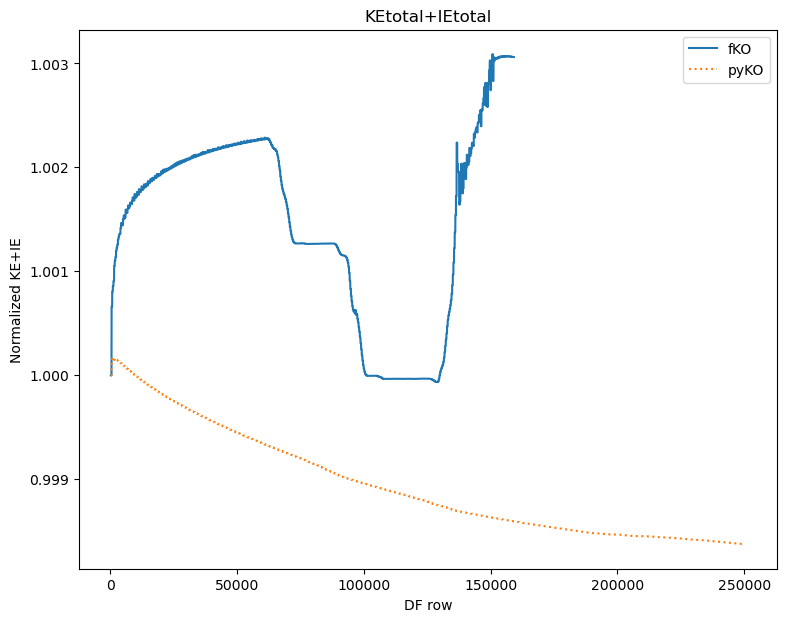

In [26]:
istart = np.where(fko['time']>0.)[0]
plt.figure()
plt.plot(fko["etot"][istart]/fko["etot"][istart[0]],label='fKO')
istart = np.where(pko['time']>0.)[0]
plt.plot(pko["etot"][istart]/pko["etot"][istart[0]],':',label='pyKO')
plt.xlabel('DF row')
plt.title('KEtotal+IEtotal')
plt.ylabel('Normalized KE+IE')
plt.legend()
plt.show()

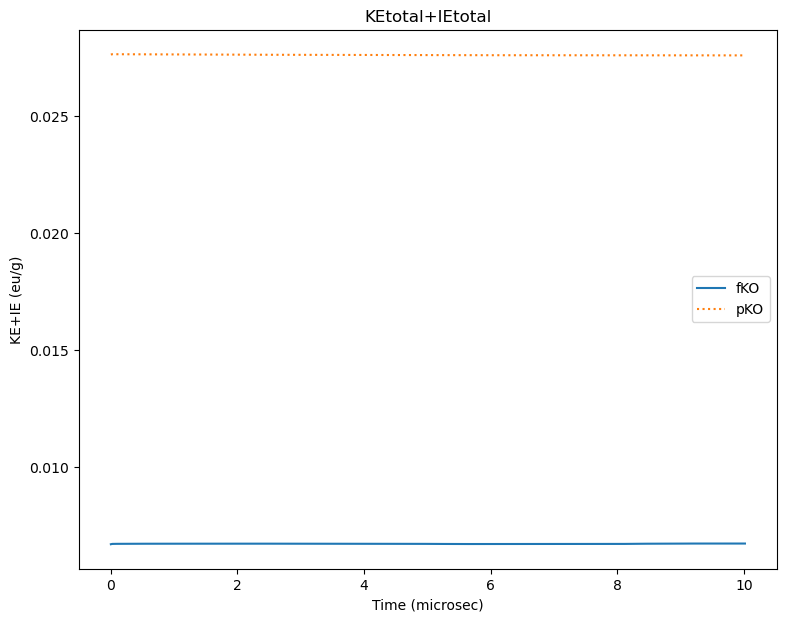

In [27]:
plt.figure()
plt.plot(fko['time'],fko['etot'],label='fKO')
plt.plot(pko['time'],pko['etot'],':',label='pKO')
plt.xlabel('Time (microsec)')
plt.title('KEtotal+IEtotal')
plt.ylabel('KE+IE (eu/g)')
plt.legend()
plt.show()

There is a units conversion problem somewhere for etot

### Make a movie of the pyKO sim

In [28]:
tarr = np.unique(pko["time"])
ntime = len(tarr)
imat1 = np.where((pko['mat'] == 1) & (pko['time'] == tarr[0]))[0]
#print(imat1)
#list(pko)
print(ntime)

1001


Click to start/stop the animation


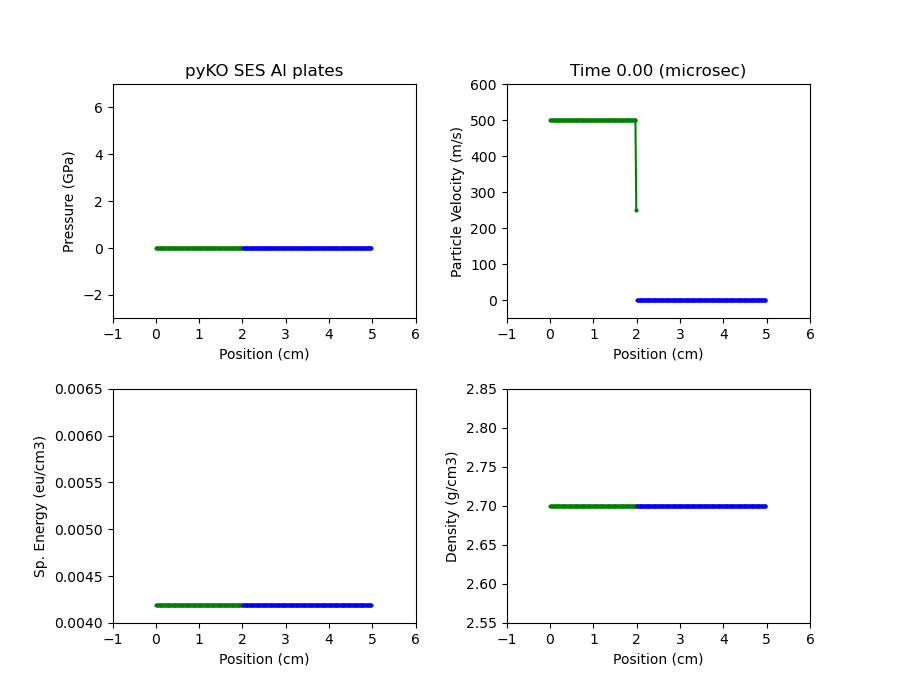

In [29]:
%matplotlib ipympl

class PauseAnimation:

    def __init__(self):
        plt.rcParams["figure.figsize"] = (9,7)
        plt.rcParams["lines.markersize"] = 2
        
        figa, axs = plt.subplots(2, 2)
        plt.subplots_adjust(wspace=0.3, hspace=0.3)


        axs[0,0].set_xlabel('Position (cm)')
        axs[0,0].set_ylabel('Pressure (GPa)')
        axs[0,0].set_xlim(-1, 6.)
        axs[0,0].set_ylim(-3,7)


        axs[0,1].set_xlabel('Position (cm)')
        axs[0,1].set_ylabel('Particle Velocity (m/s)')
        axs[0,1].set_xlim(-1, 6.)
        axs[0,1].set_ylim(-50,600)


        axs[1,1].set_xlabel('Position (cm)')
        axs[1,1].set_ylabel('Density (g/cm3)')
        axs[1,1].set_xlim(-1, 6.)
        axs[1,1].set_ylim(2.55,2.85)

        axs[1,0].set_xlabel('Position (cm)')
        axs[1,0].set_ylabel('Sp. Energy (eu/cm3)')
        axs[1,0].set_xlim(-1, 6.)
        axs[1,0].set_ylim(0.004,.0065)

        # add title of the problem and time to the top of the plot
        axs[0,0].set_title('pyKO SES Al plates')
        i=0
        timeplot = tarr[i]
        timelabel = axs[0,1].set_title('Time %.2f (microsec)' % timeplot)
        
        imat1 = np.where((pko['mat'] == 1) & (pko['time'] == tarr[i]))[0]
        imat2 = np.where((pko['mat'] == 2) & (pko['time'] == tarr[i]))[0]
        imat2 = np.delete(imat2,-1)        

        fig00a,=axs[0,0].plot(pko['pos'][imat1],pko['pres'][imat1],'g-o')
        fig00b,=axs[0,0].plot(pko['pos'][imat2],pko['pres'][imat2],'b-o')

        fig01a,=axs[0,1].plot(pko['pos'][imat1],pko['up'][imat1],'g-o')
        fig01b,=axs[0,1].plot(pko['pos'][imat2],pko['up'][imat2],'b-o')

        fig11a,=axs[1,1].plot(pko['pos'][imat1],pko['rho'][imat1],'g-o')
        fig11b,=axs[1,1].plot(pko['pos'][imat2],pko['rho'][imat2],'b-o')

        fig10a,=axs[1,0].plot(pko['pos'][imat1],pko['iev0'][imat1],'g-o')
        fig10b,=axs[1,0].plot(pko['pos'][imat2],pko['iev0'][imat2],'b-o')

        def animate4(i):
            timeplot = tarr[i]
            timelabel.set_text('Time: %.2f (microsec)' % timeplot)
            imat1 = np.where((pko['mat'] == 1) & (pko['time'] == tarr[i]))[0]
            imat2 = np.where((pko['mat'] == 2) & (pko['time'] == tarr[i]))[0]
            imat2 = np.delete(imat2,-1)
            fig00a.set_data(pko['pos'][imat1],pko['pres'][imat1])
            fig00b.set_data(pko['pos'][imat2],pko['pres'][imat2])
            fig01a.set_data(pko['pos'][imat1],pko['up'][imat1])
            fig01b.set_data(pko['pos'][imat2],pko['up'][imat2])
            fig11a.set_data(pko['pos'][imat1],pko['rho'][imat1])
            fig11b.set_data(pko['pos'][imat2],pko['rho'][imat2])
            fig10a.set_data(pko['pos'][imat1],pko['iev0'][imat1])
            fig10b.set_data(pko['pos'][imat2],pko['iev0'][imat2])

        #self.animation = animation.FuncAnimation(figa, animate4, interval=200, frames=range(0,ntime,1))
        self.animation = animation.FuncAnimation(figa, animate4, interval=200, frames=range(0,100,10))
        #self.animation = animation.FuncAnimation(figa, animate4, interval=200, frames=range(0,0))
        #HTML(self.animation.to_html5_video())
        self.paused = False
        figa.canvas.mpl_connect('button_press_event', self.toggle_pause)


    def toggle_pause(self, *args, **kwargs):
        if self.paused:
            self.animation.resume()
        else:
            self.animation.pause()
        self.paused = not self.paused

    def makemovie(self):
            writer = FFMpegWriter(fps=30, metadata=dict(artist='Me'), bitrate=1800)
            self.animation.save("./test4/pyko-test4.mp4", writer=writer)
            
    def to_html5(self):
            self.animation.to_html5_video()

pa = PauseAnimation()
print('Click to start/stop the animation')
plt.show()

In [30]:
# if you want to save a movie of the animation in the previous cell, run this command
# pa.makemovie()

In [31]:
ftarr = np.unique(fko["time"])


Click to start/stop the animation


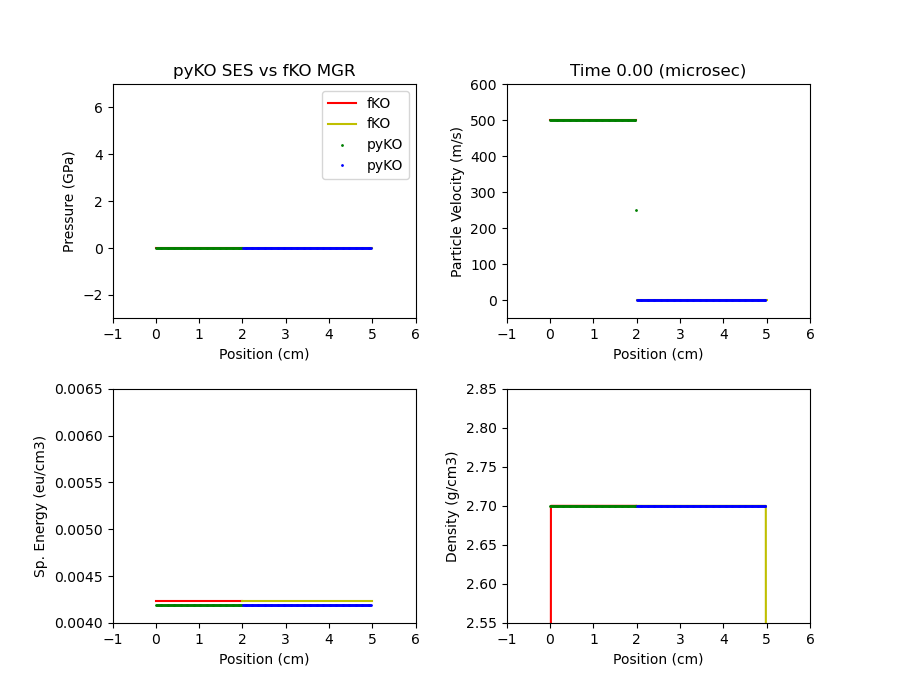

In [32]:
%matplotlib ipympl

class PauseAnimation:

    def __init__(self):
        plt.rcParams["figure.figsize"] = (9,7)
        plt.rcParams["lines.markersize"] = 1
        
        figa, axs = plt.subplots(2, 2)
        plt.subplots_adjust(wspace=0.3, hspace=0.3)


        axs[0,0].set_xlabel('Position (cm)')
        axs[0,0].set_ylabel('Pressure (GPa)')
        axs[0,0].set_xlim(-1, 6.)
        axs[0,0].set_ylim(-3,7)


        axs[0,1].set_xlabel('Position (cm)')
        axs[0,1].set_ylabel('Particle Velocity (m/s)')
        axs[0,1].set_xlim(-1, 6.)
        axs[0,1].set_ylim(-50,600)


        axs[1,1].set_xlabel('Position (cm)')
        axs[1,1].set_ylabel('Density (g/cm3)')
        axs[1,1].set_xlim(-1, 6.)
        axs[1,1].set_ylim(2.55,2.85)

        axs[1,0].set_xlabel('Position (cm)')
        axs[1,0].set_ylabel('Sp. Energy (eu/cm3)')
        axs[1,0].set_xlim(-1, 6.)
        axs[1,0].set_ylim(0.004,.0065)

        # add title of the problem and time to the top of the plot
        axs[0,0].set_title('pyKO SES vs fKO MGR')
        i=0
        timeplot = tarr[i]
        timelabel = axs[0,1].set_title('Time %.2f (microsec)' % timeplot)
        
        imat1 = np.where((pko['mat'] == 1) & (pko['time'] == tarr[i]))[0]
        imat2 = np.where((pko['mat'] == 2) & (pko['time'] == tarr[i]))[0]
        imat2 = np.delete(imat2,-1)        

        fimat1 = np.where((fko['mat'] == 1) & (fko['time'] == ftarr[i]))[0]
        fimat2 = np.where((fko['mat'] == 2) & (fko['time'] == ftarr[i]))[0]

        fig00c,=axs[0,0].plot(fko['pos'][fimat1],fko['pres'][fimat1],'r-',label='fKO')
        fig00d,=axs[0,0].plot(fko['pos'][fimat2],fko['pres'][fimat2],'y-',label='fKO')
        fig00a,=axs[0,0].plot(pko['pos'][imat1],pko['pres'][imat1],'go',label='pyKO')
        fig00b,=axs[0,0].plot(pko['pos'][imat2],pko['pres'][imat2],'bo',label='pyKO')
        axs[0,0].legend()

        fig01c,=axs[0,1].plot(fko['pos'][fimat1],fko['up'][fimat1],'r-')
        fig01d,=axs[0,1].plot(fko['pos'][fimat2],fko['up'][fimat2],'y-')
        fig01a,=axs[0,1].plot(pko['pos'][imat1],pko['up'][imat1],'go')
        fig01b,=axs[0,1].plot(pko['pos'][imat2],pko['up'][imat2],'bo')

        fig11c,=axs[1,1].plot(fko['pos'][fimat1],fko['rho'][fimat1],'r-')
        fig11d,=axs[1,1].plot(fko['pos'][fimat2],fko['rho'][fimat2],'y-')
        fig11a,=axs[1,1].plot(pko['pos'][imat1],pko['rho'][imat1],'go')
        fig11b,=axs[1,1].plot(pko['pos'][imat2],pko['rho'][imat2],'bo')

        fig10c,=axs[1,0].plot(fko['pos'][fimat1],fko['iev0'][fimat1],'r-')
        fig10d,=axs[1,0].plot(fko['pos'][fimat2],fko['iev0'][fimat2],'y-')
        fig10a,=axs[1,0].plot(pko['pos'][imat1],pko['iev0'][imat1],'go')
        fig10b,=axs[1,0].plot(pko['pos'][imat2],pko['iev0'][imat2],'bo')

        def animate4(i):
            timeplot = tarr[i]
            timelabel.set_text('Time: %.2f (microsec)' % timeplot)
            imat1 = np.where((pko['mat'] == 1) & (pko['time'] == tarr[i]))[0]
            imat2 = np.where((pko['mat'] == 2) & (pko['time'] == tarr[i]))[0]
            imat2 = np.delete(imat2,-1)
            fimat1 = np.where((fko['mat'] == 1) & (fko['time'] == ftarr[i]))[0]
            fimat2 = np.where((fko['mat'] == 2) & (fko['time'] == ftarr[i]))[0]
            fig00c.set_data(fko['pos'][fimat1],fko['pres'][fimat1])
            fig00d.set_data(fko['pos'][fimat2],fko['pres'][fimat2])
            fig00a.set_data(pko['pos'][imat1],pko['pres'][imat1])
            fig00b.set_data(pko['pos'][imat2],pko['pres'][imat2])

            fig01c.set_data(fko['pos'][fimat1],fko['up'][fimat1])
            fig01d.set_data(fko['pos'][fimat2],fko['up'][fimat2])
            fig01a.set_data(pko['pos'][imat1],pko['up'][imat1])
            fig01b.set_data(pko['pos'][imat2],pko['up'][imat2])
            
            fig11c.set_data(fko['pos'][fimat1],fko['rho'][fimat1])
            fig11d.set_data(fko['pos'][fimat2],fko['rho'][fimat2])
            fig11a.set_data(pko['pos'][imat1],pko['rho'][imat1])
            fig11b.set_data(pko['pos'][imat2],pko['rho'][imat2])
            
            fig10c.set_data(fko['pos'][fimat1],fko['iev0'][fimat1])
            fig10d.set_data(fko['pos'][fimat2],fko['iev0'][fimat2])
            fig10a.set_data(pko['pos'][imat1],pko['iev0'][imat1])
            fig10b.set_data(pko['pos'][imat2],pko['iev0'][imat2])

        self.animation = animation.FuncAnimation(figa, animate4, interval=200, frames=range(0,ntime,1))
        #self.animation = animation.FuncAnimation(figa, animate4, interval=200, frames=range(0,0))

        self.paused = False

        figa.canvas.mpl_connect('button_press_event', self.toggle_pause)


    def toggle_pause(self, *args, **kwargs):
        if self.paused:
            self.animation.resume()
        else:
            self.animation.pause()
        self.paused = not self.paused

    def makemovie(self):
            writer = FFMpegWriter(fps=30, metadata=dict(artist='Me'), bitrate=1800)
            self.animation.save("./test4/pyko-v-fko-test4-energy.mp4", writer=writer)

pa2 = PauseAnimation()
print('Click to start/stop the animation')
plt.show()

In [33]:
# if you want to save a movie of the animation in the previous cell, run this command
#pa2.makemovie()

Click to start/stop the animation


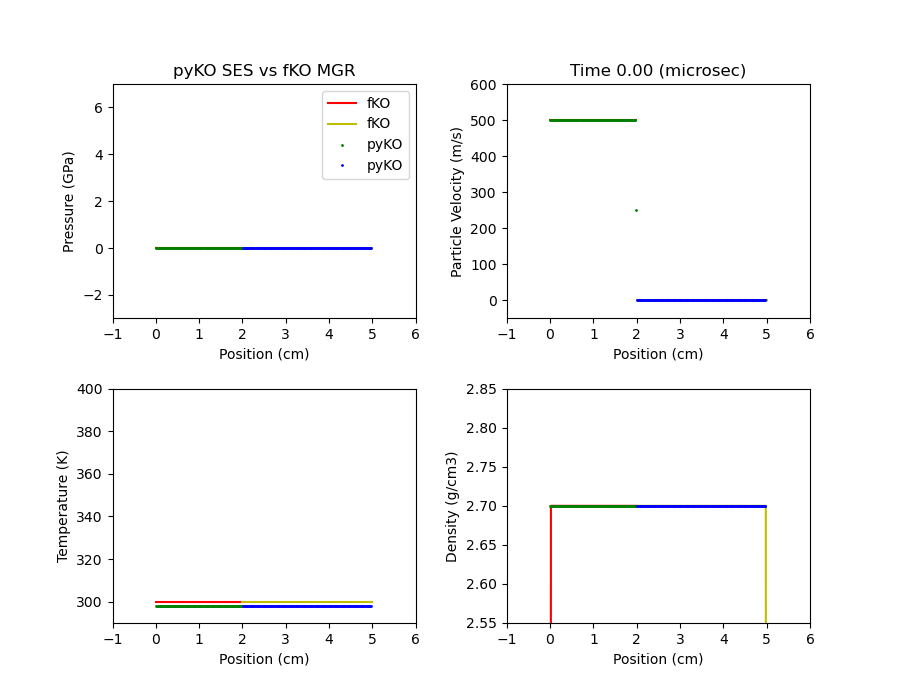

In [34]:
%matplotlib ipympl

class PauseAnimation:

    def __init__(self):
        plt.rcParams["figure.figsize"] = (9,7)
        plt.rcParams["lines.markersize"] = 1
        
        figa, axs = plt.subplots(2, 2)
        plt.subplots_adjust(wspace=0.3, hspace=0.3)


        axs[0,0].set_xlabel('Position (cm)')
        axs[0,0].set_ylabel('Pressure (GPa)')
        axs[0,0].set_xlim(-1, 6.)
        axs[0,0].set_ylim(-3,7)


        axs[0,1].set_xlabel('Position (cm)')
        axs[0,1].set_ylabel('Particle Velocity (m/s)')
        axs[0,1].set_xlim(-1, 6.)
        axs[0,1].set_ylim(-50,600)


        axs[1,1].set_xlabel('Position (cm)')
        axs[1,1].set_ylabel('Density (g/cm3)')
        axs[1,1].set_xlim(-1, 6.)
        axs[1,1].set_ylim(2.55,2.85)

        axs[1,0].set_xlabel('Position (cm)')
        axs[1,0].set_ylabel('Temperature (K)')
        axs[1,0].set_xlim(-1, 6.)
        axs[1,0].set_ylim(290,400)

        # add title of the problem and time to the top of the plot
        axs[0,0].set_title('pyKO SES vs fKO MGR')
        i=0
        timeplot = tarr[i]
        timelabel = axs[0,1].set_title('Time %.2f (microsec)' % timeplot)
        
        imat1 = np.where((pko['mat'] == 1) & (pko['time'] == tarr[i]))[0]
        imat2 = np.where((pko['mat'] == 2) & (pko['time'] == tarr[i]))[0]
        imat2 = np.delete(imat2,-1)        

        fimat1 = np.where((fko['mat'] == 1) & (fko['time'] == ftarr[i]))[0]
        fimat2 = np.where((fko['mat'] == 2) & (fko['time'] == ftarr[i]))[0]

        fig00c,=axs[0,0].plot(fko['pos'][fimat1],fko['pres'][fimat1],'r-',label='fKO')
        fig00d,=axs[0,0].plot(fko['pos'][fimat2],fko['pres'][fimat2],'y-',label='fKO')
        fig00a,=axs[0,0].plot(pko['pos'][imat1],pko['pres'][imat1],'go',label='pyKO')
        fig00b,=axs[0,0].plot(pko['pos'][imat2],pko['pres'][imat2],'bo',label='pyKO')
        axs[0,0].legend()

        fig01c,=axs[0,1].plot(fko['pos'][fimat1],fko['up'][fimat1],'r-')
        fig01d,=axs[0,1].plot(fko['pos'][fimat2],fko['up'][fimat2],'y-')
        fig01a,=axs[0,1].plot(pko['pos'][imat1],pko['up'][imat1],'go')
        fig01b,=axs[0,1].plot(pko['pos'][imat2],pko['up'][imat2],'bo')

        fig11c,=axs[1,1].plot(fko['pos'][fimat1],fko['rho'][fimat1],'r-')
        fig11d,=axs[1,1].plot(fko['pos'][fimat2],fko['rho'][fimat2],'y-')
        fig11a,=axs[1,1].plot(pko['pos'][imat1],pko['rho'][imat1],'go')
        fig11b,=axs[1,1].plot(pko['pos'][imat2],pko['rho'][imat2],'bo')

        fig10c,=axs[1,0].plot(fko['pos'][fimat1],fko['temp'][fimat1],'r-')
        fig10d,=axs[1,0].plot(fko['pos'][fimat2],fko['temp'][fimat2],'y-')
        fig10a,=axs[1,0].plot(pko['pos'][imat1],pko['temp'][imat1],'go')
        fig10b,=axs[1,0].plot(pko['pos'][imat2],pko['temp'][imat2],'bo')

        def animate4(i):
            timeplot = tarr[i]
            timelabel.set_text('Time: %.2f (microsec)' % timeplot)
            imat1 = np.where((pko['mat'] == 1) & (pko['time'] == tarr[i]))[0]
            imat2 = np.where((pko['mat'] == 2) & (pko['time'] == tarr[i]))[0]
            imat2 = np.delete(imat2,-1)
            fimat1 = np.where((fko['mat'] == 1) & (fko['time'] == ftarr[i]))[0]
            fimat2 = np.where((fko['mat'] == 2) & (fko['time'] == ftarr[i]))[0]
            fig00c.set_data(fko['pos'][fimat1],fko['pres'][fimat1])
            fig00d.set_data(fko['pos'][fimat2],fko['pres'][fimat2])
            fig00a.set_data(pko['pos'][imat1],pko['pres'][imat1])
            fig00b.set_data(pko['pos'][imat2],pko['pres'][imat2])

            fig01c.set_data(fko['pos'][fimat1],fko['up'][fimat1])
            fig01d.set_data(fko['pos'][fimat2],fko['up'][fimat2])
            fig01a.set_data(pko['pos'][imat1],pko['up'][imat1])
            fig01b.set_data(pko['pos'][imat2],pko['up'][imat2])
            
            fig11c.set_data(fko['pos'][fimat1],fko['rho'][fimat1])
            fig11d.set_data(fko['pos'][fimat2],fko['rho'][fimat2])
            fig11a.set_data(pko['pos'][imat1],pko['rho'][imat1])
            fig11b.set_data(pko['pos'][imat2],pko['rho'][imat2])
            
            fig10c.set_data(fko['pos'][fimat1],fko['temp'][fimat1])
            fig10d.set_data(fko['pos'][fimat2],fko['temp'][fimat2])
            fig10a.set_data(pko['pos'][imat1],pko['temp'][imat1])
            fig10b.set_data(pko['pos'][imat2],pko['temp'][imat2])

        self.animation = animation.FuncAnimation(figa, animate4, interval=200, frames=range(0,ntime,1))
        #self.animation = animation.FuncAnimation(figa, animate4, interval=200, frames=range(0,0))

        self.paused = False

        figa.canvas.mpl_connect('button_press_event', self.toggle_pause)


    def toggle_pause(self, *args, **kwargs):
        if self.paused:
            self.animation.resume()
        else:
            self.animation.pause()
        self.paused = not self.paused

    def makemovie(self):
            writer = FFMpegWriter(fps=30, metadata=dict(artist='Me'), bitrate=1800)
            self.animation.save("./test4/pyko-v-fko-test4-temp.mp4", writer=writer)

pa3 = PauseAnimation()
print('Click to start/stop the animation')
plt.show()

In [35]:
# if you want to save a movie of the animation in the previous cell, run this command
#pa3.makemovie()

End of notebook